In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
z500_anoms = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/DailyDetrendedStdAnoms_v3/Z500_ERA5_Region.nc')

dataset_raw = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/DailyDatasets/Z500_ERA5.nc')
dataset_raw = dataset_raw.sel(time=pd.to_datetime(dataset_raw.time)<'2021-01-01')

In [3]:
# region for clustering
lat0 = 20; lat1 = 80; lon0 = 180; lon1 = 330

z500_anoms_region = z500_anoms.where((z500_anoms.lat>=lat0)&(z500_anoms.lat<=lat1)&\
                   (z500_anoms.lon>=lon0)&(z500_anoms.lon<=lon1),drop=True)
z500_anoms_region = z500_anoms_region.sel(time=pd.to_datetime(z500_anoms_region.time)<'2021-01-01')

In [4]:
var_name = 'Z_anomalies'

In [5]:
z500_anoms_flattened = z500_anoms_region.stack(flat=('lat','lon')).transpose('time','flat')[var_name]
# z500_anoms_flattened = z500_anoms_flattened.data

In [6]:
import joblib
pca_obj = joblib.load(r'/glade/work/jhayron/Data4Predictability/PCA_ERA5_v20241226.mdl')
k_means = joblib.load(r'/glade/work/jhayron/Data4Predictability/KMeans_ERA5_v20241226.mdl')
# data_era5_train = pca_obj.transform(data_era5_train)

In [7]:
z500_anoms_transformed = pca_obj.transform(z500_anoms_flattened)

In [8]:
anomalies_afterPCA = copy.deepcopy(z500_anoms_flattened)
anomalies_afterPCA.data = pca_obj.inverse_transform(z500_anoms_transformed)
anomalies_afterPCA = anomalies_afterPCA.unstack('flat')

In [9]:
initial_cluster_centers = k_means.cluster_centers_
new_cluster_centers = np.vstack([initial_cluster_centers,np.zeros(12)]) #Added a new center at 0,0,...,0 for unknown WR

In [10]:
#sort by frequency
new_cluster_centers = new_cluster_centers[[1,3,0,2,4]]

In [11]:
# weather_patterns = k_means.predict(z500_anoms_transformed)
euc_res=euclidean_distances(new_cluster_centers, z500_anoms_transformed)
weather_patterns = euc_res.argmin(axis=0)
dist = euc_res.min(axis=0)
df_test = pd.DataFrame(weather_patterns,index=pd.to_datetime(anomalies_afterPCA.time),columns=['wr'])
df_test['dist'] = dist
df_test.loc[df_test.dist>=np.percentile(df_test.dist,90),'wr'] = 4 ### Classify as No-WR the 10% that are more distant from centroid

In [12]:
where0 = np.where(df_test['wr']==0)
where1 = np.where(df_test['wr']==1)
where2 = np.where(df_test['wr']==2)
where3 = np.where(df_test['wr']==3)
where4 = np.where(df_test['wr']==4)

print('Pattern #0:')
print(np.round(100*len(where0[0])/len(weather_patterns),2))

print('Pattern #1:')
print(np.round(100*len(where1[0])/len(weather_patterns),2))

print('Pattern #2:')
print(np.round(100*len(where2[0])/len(weather_patterns),2))

print('Pattern #3:')
print(np.round(100*len(where3[0])/len(weather_patterns),2))

print('Pattern #4:')
print(np.round(100*len(where4[0])/len(weather_patterns),2))

p0 = np.round(len(where0[0])/len(weather_patterns),2)
p1 = np.round(len(where1[0])/len(weather_patterns),2)
p2 = np.round(len(where2[0])/len(weather_patterns),2)
p3 = np.round(len(where3[0])/len(weather_patterns),2)
p4 = np.round(len(where4[0])/len(weather_patterns),2)

Pattern #0:
24.92
Pattern #1:
21.9
Pattern #2:
17.4
Pattern #3:
13.66
Pattern #4:
22.11


In [13]:
df_test

,wr,dist
1981-01-02,4,2.781412
1981-01-03,4,2.786442
1981-01-04,2,2.713289
1981-01-05,2,2.709316
1981-01-06,2,2.764666
...,...,...
2020-12-27,0,2.955757
2020-12-28,0,2.943188
2020-12-29,0,2.808286
2020-12-30,0,2.624639


# Precipitation composites

In [33]:
data_mm_day = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/PRECIP_ERA5_Daily.nc')
data_mm_day = data_mm_day.sel(time=slice('1981-01-01','2020-12-31'))

data_mm_day = data_mm_day.PrecipitationRate * 3600
data_mm_day = data_mm_day * 24
data_mm_day.attrs['long_name'] = 'Daily cumulative precipitation'
data_mm_day.attrs['units'] = 'mm/day'
data_mm_day = data_mm_day.to_dataset(name='DailyPrecip')
## Mask ##

lsm = xr.open_dataset('/glade/campaign/collections/rda/data/d633000/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')
lsm = lsm.sel(latitude=data_mm_day.lat,longitude=data_mm_day.lon)
lsm = lsm.LSM.isel(time=0)
lsm = lsm.astype(bool)
mask_arr = lsm.data.astype(float)
mask_arr[mask_arr==False]=np.nan
data_arr = data_mm_day.DailyPrecip.data
data_arr = data_arr*mask_arr
data_mm_day.DailyPrecip.data = data_arr

In [34]:
data_mm_day

<xarray.Dataset>
Dimensions:      (lat: 241, lon: 601, time: 14610)
Coordinates:
  * lat          (lat) float64 20.0 20.25 20.5 20.75 ... 79.25 79.5 79.75 80.0
  * lon          (lon) float64 180.0 180.2 180.5 180.8 ... 329.5 329.8 330.0
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2020-12-31
Data variables:
    DailyPrecip  (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0

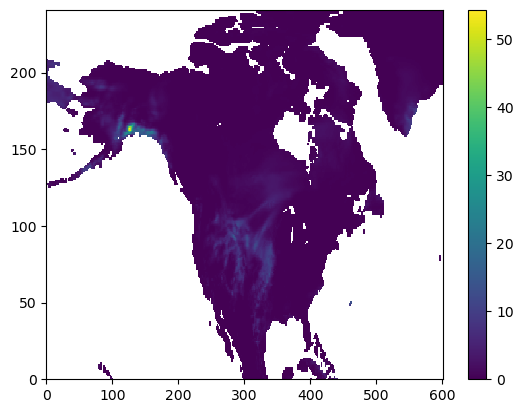

In [35]:
plt.pcolormesh(data_mm_day.DailyPrecip.isel(time=30))
plt.colorbar()

In [36]:
DailyPrecip = data_mm_day.DailyPrecip
climatology = (
    DailyPrecip.groupby('time.dayofyear')
    .mean(dim='time')
    .rename({'dayofyear': 'day'})
)
climatology_padded = xr.concat([climatology[-30:], climatology, climatology[:30]], dim='day')
climatology_smoothed = climatology_padded.rolling(day=60, center=True).mean()
climatology_smoothed = climatology_smoothed.isel(day=slice(30, -30))

climatology_expanded = xr.DataArray(
    climatology_smoothed.sel(day=DailyPrecip['time.dayofyear']),
    dims=["time", "lat", "lon"],
    coords={"time": DailyPrecip['time'], "lat": DailyPrecip['lat'], "lon": DailyPrecip['lon']}
)

climatology_std = (
    DailyPrecip.groupby('time.dayofyear')
    .std(dim='time')
    .rename({'dayofyear': 'day'})
)

climatology_std_padded = xr.concat([climatology_std[-30:], climatology_std, climatology_std[:30]], dim='day')
climatology_std_smoothed = climatology_std_padded.rolling(day=60, center=True).mean()
climatology_std_smoothed = climatology_std_smoothed.isel(day=slice(30, -30))

climatology_std_expanded = xr.DataArray(
    climatology_std_smoothed.sel(day=DailyPrecip['time.dayofyear']),
    dims=["time", "lat", "lon"],
    coords={"time": DailyPrecip['time'], "lat": DailyPrecip['lat'], "lon": DailyPrecip['lon']}
)
precipitation_anomalies = DailyPrecip - climatology_expanded
precipitation_anomalies_std = precipitation_anomalies / climatology_std_expanded

del(precipitation_anomalies)
del(climatology_std_smoothed)
del(climatology_std_expanded)
del(climatology_std_padded)
del(climatology_std)
del(climatology_expanded)
del(DailyPrecip)
del(climatology_padded)
del(climatology_smoothed)
del(data_mm_day)

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarnin

In [37]:
indices_seasons = {'Winter':[12,1,2],
                   'Spring':[3,4,5],
                   'Summer':[6,7,8],
                   'Fall':[9,10,11],
                   'All':[1,2,3,4,5,6,7,8,9,10,11,12]}

In [38]:
dic_composites_precip = {}
dic_significance_precip = {}
for wr in range(5):
    for iseason, season in enumerate(indices_seasons.keys()):
        if season!='All':
            df_test_season = df_test.loc[(df_test.index.month==indices_seasons[season][0])|\
                            (df_test.index.month==indices_seasons[season][1])|\
                            (df_test.index.month==indices_seasons[season][2])]
        else:
            df_test_season = copy.deepcopy(df_test)
            # aaaa
        precip_temp = precipitation_anomalies_std.sel(time=df_test_season[df_test_season['wr']==wr].index)
        dic_composites_precip[f'{wr}_{season}'] = precip_temp.mean('time')
    
        # boot_num_init_ = 1000
        # boot_num_iter_ = 10
        
        # boots_means = []
        # for ind in range(boot_num_init_, boot_num_init_+boot_num_iter_):
        #     np.random.seed(ind + 1)
        #     rand_indx = [np.random.choice(precipitation_anomalies_std.shape[0]) for i in range(precip_temp.shape[0])]
        #     mean_boot = precipitation_anomalies_std.isel(time=rand_indx).mean('time')
        #     boots_means.append(mean_boot)
        
        # boots_means = np.array(boots_means)
        # p05 = np.quantile(boots_means,0.05,axis=0)
        # p95 = np.quantile(boots_means,0.95,axis=0)
        # significance = (dic_composites[f'{wr}_{season}']>=p95)|(dic_composites[f'{wr}_{season}']<=p05)
        # dic_significance[f'{wr}_{season}'] = significance

# Temperature composites

In [19]:
def compute_anoms(da):
    clima = (da.groupby('time.dayofyear').mean(dim='time').rename({'dayofyear': 'day'}))
    clima_padded = xr.concat([clima[-30:], clima, clima[:30]], dim='day')
    clima_smoothed = clima_padded.rolling(day=60, center=True).mean()
    clima_smoothed = clima_smoothed.isel(day=slice(30, -30))
    clima_expanded = xr.DataArray(
        clima_smoothed.sel(day=da['time.dayofyear']),
        dims=["time", "lat", "lon"],
        coords={"time": da['time'], "lat": da['lat'], "lon": da['lon']}
    )
    anoms = da - clima_expanded

    clima_std = (da.groupby('time.dayofyear').std(dim='time').rename({'dayofyear': 'day'}))
    clima_std_padded = xr.concat([clima_std[-30:], clima_std, clima_std[:30]], dim='day')
    clima_std_smoothed = clima_std_padded.rolling(day=60, center=True).mean()
    clima_std_smoothed = clima_std_smoothed.isel(day=slice(30, -30))
    clima_std_expanded = xr.DataArray(
        clima_std_smoothed.sel(day=da['time.dayofyear']),
        dims=["time", "lat", "lon"],
        coords={"time": da['time'], "lat": da['lat'], "lon": da['lon']}
    )

    anoms_std = anoms/clima_std_expanded
    return anoms, anoms_std

In [20]:
meantemp = xr.open_dataset('/glade/derecho/scratch/jhayron/Data4Predictability/TMean_ERA5_Daily.nc').MeanTemp.compute()
## Mask ##

lsm = xr.open_dataset('/glade/campaign/collections/rda/data/d633000/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')
lsm = lsm.sel(latitude=meantemp.lat,longitude=meantemp.lon)
lsm = lsm.LSM.isel(time=0)
lsm = lsm.astype(bool)
mask_arr = lsm.data.astype(float)
mask_arr[mask_arr==False]=np.nan
data_arr = meantemp.data
data_arr = data_arr*mask_arr
meantemp.data = data_arr

In [21]:
_,anoms_temp_std = compute_anoms(meantemp)

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarnin

In [22]:
dic_composites_temp = {}
dic_significance_temp = {}
for wr in range(5):
    for iseason, season in enumerate(indices_seasons.keys()):
        if season!='All':
            df_test_season = df_test.loc[(df_test.index.month==indices_seasons[season][0])|\
                            (df_test.index.month==indices_seasons[season][1])|\
                            (df_test.index.month==indices_seasons[season][2])]
        else:
            df_test_season = copy.deepcopy(df_test)
            # aaaa
        temp_temp = anoms_temp_std.sel(time=df_test_season[df_test_season['wr']==wr].index)
        dic_composites_temp[f'{wr}_{season}'] = temp_temp.mean('time')
    
        # boot_num_init_ = 1000
        # boot_num_iter_ = 10
        
        # boots_means = []
        # for ind in range(boot_num_init_, boot_num_init_+boot_num_iter_):
        #     np.random.seed(ind + 1)
        #     rand_indx = [np.random.choice(precipitation_anomalies_std.shape[0]) for i in range(precip_temp.shape[0])]
        #     mean_boot = precipitation_anomalies_std.isel(time=rand_indx).mean('time')
        #     boots_means.append(mean_boot)
        
        # boots_means = np.array(boots_means)
        # p05 = np.quantile(boots_means,0.05,axis=0)
        # p95 = np.quantile(boots_means,0.95,axis=0)
        # significance = (dic_composites[f'{wr}_{season}']>=p95)|(dic_composites[f'{wr}_{season}']<=p05)
        # dic_significance[f'{wr}_{season}'] = significance

# plot all composites

In [23]:
mean_wr_0 = z500_anoms.Z_anomalies[where0].mean(axis=0)#/9.82
mean_wr_1 = z500_anoms.Z_anomalies[where1].mean(axis=0)#/9.82
mean_wr_2 = z500_anoms.Z_anomalies[where2].mean(axis=0)#/9.82
mean_wr_3 = z500_anoms.Z_anomalies[where3].mean(axis=0)#/9.82
mean_wr_4 = z500_anoms.Z_anomalies[where4].mean(axis=0)#/9.82

composites = [mean_wr_0.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_1.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_2.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_3.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon),
              mean_wr_4.sel(lat=z500_anoms_region.lat,lon=z500_anoms_region.lon)
             ]

In [24]:
import string
abcd = list(string.ascii_lowercase)

/glade/derecho/scratch/jhayron/tmp/ipykernel_235245/487139677.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


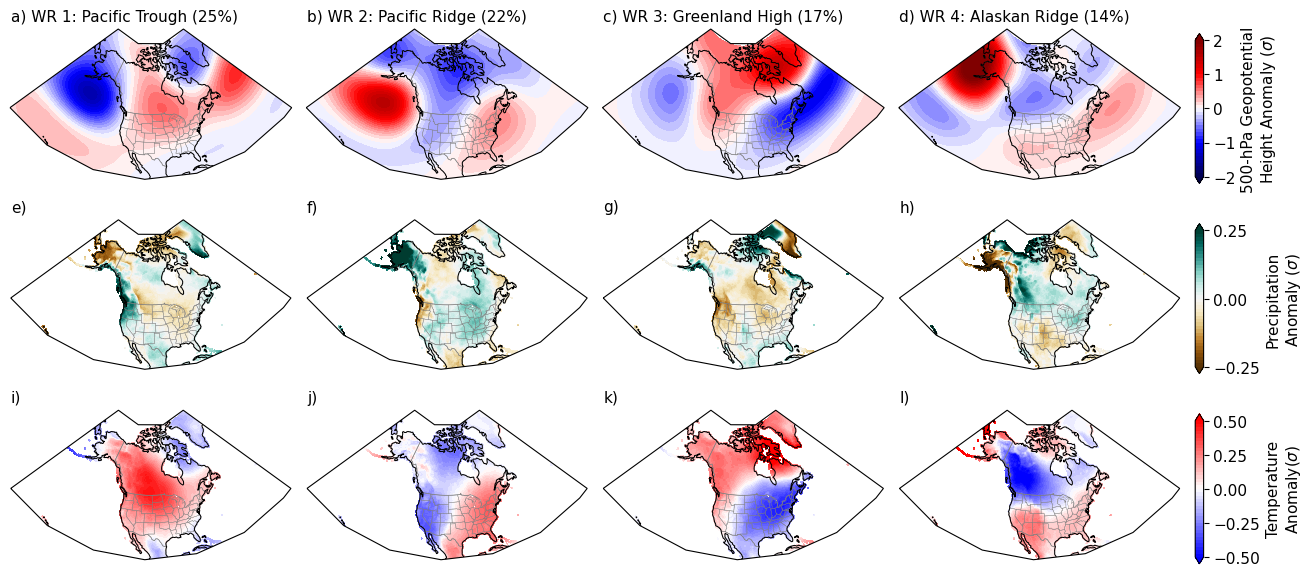

In [59]:
names = ['Pacific Trough','Pacific Ridge','Greenland High','Alaskan Ridge']
probs = [p0,p1,p2,p3]

# ---

fig, axs = plt.subplots(
    3, 4,
    subplot_kw=dict(projection = ccrs.AlbersEqualArea(
                        central_longitude=-105,  # Center of your region
                        central_latitude=50,    # Approximate midpoint latitude
                        standard_parallels=(30, 70)  # Standard parallels
                    )
                    ),
    figsize=(12, 6))

axs_list = axs.flatten().tolist()
# ---
mini=-2
maxi=2
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,4):
    pm = axs_list[iregime].contourf(composites[iregime].lon, composites[iregime].lat, composites[iregime],
                         transform=ccrs.PlateCarree(), levels=bounds,
                         vmin=mini, vmax=maxi, cmap='seismic',extend='both')

    axs_list[iregime].set_title(
        f'{abcd[iregime]}) WR {iregime+1}: {names[iregime]} ({int(np.around((probs[iregime]) * 100))}%)', 
        fontsize=11,loc='left')

    axs_list[iregime].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs_list[iregime].margins(x=0, y=0)
    axs_list[iregime].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
    axs_list[iregime].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders


    extent = [-180, -30, 20, 80]
    # Create a rectangular boundary matching the extent
    verts = [
        (extent[0], extent[2]),  # Bottom-left corner
        (extent[1], extent[2]),  # Bottom-right corner
        (extent[1], extent[3]),  # Top-right corner
        (extent[0], extent[3]),  # Top-left corner
        (extent[0], extent[2])   # Closing the rectangle
    ]
    rect = mpath.Path(verts)
    
    # Set the boundary of the plot
    axs_list[iregime].set_boundary(rect, transform=ccrs.PlateCarree())

# ---

cbar_ax = fig.add_axes([1, 0.68, 0.007, 0.25])
ticks_1 = [-2,-1, 0, 1 ,2]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=11)
cbar.set_label('500-hPa Geopotential\nHeight Anomaly ($\sigma$)', fontsize=11)

mini=-0.25
maxi=0.25
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,4):
    pm = axs_list[iregime+4].contourf(dic_composites_precip[f'{iregime}_All'].lon, dic_composites_precip[f'{iregime}_All'].lat, 
                                    dic_composites_precip[f'{iregime}_All'],
                                     transform=ccrs.PlateCarree(), levels=bounds,
                                     vmin=mini, vmax=maxi, cmap='BrBG',extend='both')

    axs_list[iregime+4].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs_list[iregime+4].margins(x=0, y=0)
    axs_list[iregime+4].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
    axs_list[iregime+4].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders


    extent = [-180, -30, 20, 80]
    # Create a rectangular boundary matching the extent
    verts = [
        (extent[0], extent[2]),  # Bottom-left corner
        (extent[1], extent[2]),  # Bottom-right corner
        (extent[1], extent[3]),  # Top-right corner
        (extent[0], extent[3]),  # Top-left corner
        (extent[0], extent[2])   # Closing the rectangle
    ]
    rect = mpath.Path(verts)
    
    # Set the boundary of the plot
    axs_list[iregime+4].set_boundary(rect, transform=ccrs.PlateCarree())
    axs_list[iregime+4].set_title(
            f'{abcd[iregime+4]})', 
            fontsize=11,loc='left')

cbar_ax = fig.add_axes([1, 0.363, 0.007, 0.25])
ticks_1 = [-0.25, 0, 0.25]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Precipitation\nAnomaly ($\sigma$)', fontsize=11)

mini=-0.5
maxi=0.5
intervals = 41
bounds=np.linspace(mini,maxi,intervals)

for iregime in range(0,4):
    pm = axs_list[iregime+8].contourf(dic_composites_temp[f'{iregime}_All'].lon, dic_composites_temp[f'{iregime}_All'].lat, 
                                    dic_composites_temp[f'{iregime}_All'],
                                     transform=ccrs.PlateCarree(), levels=bounds,
                                     vmin=mini, vmax=maxi, cmap='bwr',extend='both')

    axs_list[iregime+8].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs_list[iregime+8].margins(x=0, y=0)
    axs_list[iregime+8].add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=5)  # Add country borders
    axs_list[iregime+8].add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.25, zorder=5)  # Add state/province borders

    extent = [-180, -30, 20, 80]
    # Create a rectangular boundary matching the extent
    verts = [
        (extent[0], extent[2]),  # Bottom-left corner
        (extent[1], extent[2]),  # Bottom-right corner
        (extent[1], extent[3]),  # Top-right corner
        (extent[0], extent[3]),  # Top-left corner
        (extent[0], extent[2])   # Closing the rectangle
    ]
    rect = mpath.Path(verts)
    
    # Set the boundary of the plot
    axs_list[iregime+8].set_boundary(rect, transform=ccrs.PlateCarree())
    axs_list[iregime+8].set_title(
            f'{abcd[iregime+8]})', 
            fontsize=11,loc='left')

cbar_ax = fig.add_axes([1, 0.046, 0.007, 0.25])
ticks_1 = [-0.5, -0.25, 0, 0.25, 0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                    orientation='vertical', extend='both')
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Temperature\nAnomaly($\sigma$)', fontsize=11)

plt.tight_layout()
plt.savefig('1_WR_Composites_PrTp.png',bbox_inches='tight')

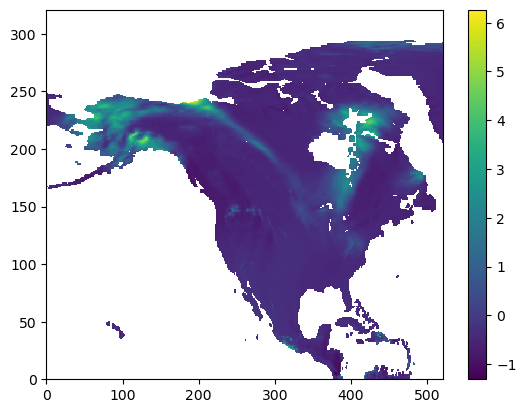

In [26]:
plt.pcolormesh(precipitation_anomalies_std.isel(time=0))
plt.colorbar()